In [ ]:
# ========================================================= #
#                   MODULES & IMPORTS                       #
# ========================================================= #

import os
import warnings

import h3
import swifter
import geopandas as gpd
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    log_loss,
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    brier_score_loss,
)
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    log_loss,
    classification_report,
    accuracy_score,
    confusion_matrix,
)
from sklearn.model_selection import GroupKFold
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, StackingClassifier

import xgboost as xgb

warnings.filterwarnings("ignore", message="The `cv='prefit'` option is deprecated")
warnings.filterwarnings("ignore", message=r".*use_label_encoder.*")


# ========================================================= #
#                      DATA HELPERS                         #
# ========================================================= #


def open_sightings(path: str) -> pd.DataFrame:
    """Open sightings data from CSV or Parquet."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Path does not exist: {path}")
    if path.endswith(".csv"):
        return pd.read_csv(path)
    if path.endswith(".parquet"):
        return pd.read_parquet(path)
    raise ValueError("Unsupported file type. Use .csv or .parquet.")


def quick_preprocess(data: pd.DataFrame, h3_resolution: int) -> pd.DataFrame:
    """Basic cleaning + H3 encoding + POD type fixes."""
    # Fix longitude sign
    data["LONGITUDE"] = np.where(
        data["LONGITUDE"] > 0, -data["LONGITUDE"], data["LONGITUDE"]
    )
    data = data[(data["LONGITUDE"] < -115) & (data["LONGITUDE"] > -160)].reset_index(
        drop=True
    )

    # H3 cell assignment
    data["H3_CELL"] = data.swifter.apply(
        lambda x: h3.latlng_to_cell(x["LATITUDE"], x["LONGITUDE"], h3_resolution),
        axis=1,
    )

    # Ensure datetime + year col
    data["DATE"] = pd.to_datetime(data["DATE"])
    data["YEAR"] = data["DATE"].dt.year

    # Pod type cleanup
    data["POD_TYPE"] = np.where(data["POD_TAG"] == "T", "TRANSIENT", data["POD_TYPE"])
    data["POD_TYPE"] = np.where(data["POD_TAG"] == "O", "OTHER", data["POD_TYPE"])
    data["POD_TYPE"] = np.where(
        data["POD_TAG"].isin(["J", "K", "L"]), "SRKW", data["POD_TYPE"]
    )
    data["POD_TYPE"] = np.where(
        ~data["POD_TAG"].isin(["J", "K", "L", "O", "T"]), "NRKW", data["POD_TYPE"]
    )

    # Group blocks: H3 + year
    data["BLOCK"] = data["H3_CELL"].astype(str) + "_" + data["YEAR"].astype(str)
    return data


def add_cyclical_features(df, cyclical_cols=None):
    """Add sin/cos transforms for cyclical temporal features."""
    cyclical_cols = cyclical_cols or {"DOY": 365, "WOY": 52, "MONTH": 12}
    for col, max_val in cyclical_cols.items():
        df[f"{col}_SIN"] = np.sin(2 * np.pi * df[col] / max_val)
        df[f"{col}_COS"] = np.cos(2 * np.pi * df[col] / max_val)
    return df


def split_data_by_categorization_other(df):
    """Split sightings into classed pods vs OTHER/NaN."""
    classed = df[df["POD_TYPE"].isin(["SRKW", "NRKW", "TRANSIENT"])].copy()
    other = df[(df["POD_TYPE"] == "OTHER") | (df["POD_TYPE"].isna())].copy()
    return classed, other


def build_feature_matrix(df, feature_cols, response):
    """Build feature matrix X and target y."""
    return df[feature_cols].copy(), df[response]


# ========================================================= #
#                   MODELING FUNCTIONS                      #
# ========================================================= #


def _safe_fit(clf, X, y, sample_weights=None):
    """Fit pipeline safely with sample weights (if supported)."""
    try:
        if sample_weights is not None:
            clf.fit(X, y, model__sample_weight=sample_weights)
        else:
            clf.fit(X, y)
    except TypeError:
        # Some models in pipelines ignore sample_weight
        clf.fit(X, y)
    return clf


def train_classifier(
    X,
    y,
    groups,
    categorical_features,
    numeric_features,
    base_model,
    sample_weights=None,
    n_splits=5,
    calibrate=True,
):
    """Train classifier with GroupKFold + OOF preds + optional calibration."""
    # Wrap if no predict_proba
    if not hasattr(base_model, "predict_proba"):
        base_model = CalibratedClassifierCV(base_model, cv=3, method="sigmoid")

    preprocessor = ColumnTransformer(
        [
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
            ("num", StandardScaler(), numeric_features),
        ]
    )

    clf = Pipeline(steps=[("preprocessor", preprocessor), ("model", base_model)])
    classes = np.unique(y)
    oof_preds = np.zeros((len(X), len(classes)))
    gkf = GroupKFold(n_splits=n_splits)

    for fold, (tr, va) in enumerate(gkf.split(X, y, groups)):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]
        w_tr = None if sample_weights is None else sample_weights.iloc[tr]

        _safe_fit(clf, X_tr, y_tr, w_tr)

        preds = clf.predict_proba(X_va)
        aligned = np.zeros((len(X_va), len(classes)))
        for i, c in enumerate(clf.named_steps["model"].classes_):
            aligned[:, np.where(classes == c)[0][0]] = preds[:, i]
        oof_preds[va] = aligned

    # Final fit
    _safe_fit(clf, X, y, sample_weights)

    # Calibrate
    if calibrate and not isinstance(clf.named_steps["model"], CalibratedClassifierCV):
        calibrator = CalibratedClassifierCV(
            estimator=clf, cv="prefit", method="isotonic"
        )
        calibrator.fit(X, y)
        return calibrator, oof_preds
    return clf, oof_preds


# ========================================================= #
#                   MODELING EVALUATION                     #
# ========================================================= #


def evaluate_model(y_true, oof_preds, classes):
    """Evaluate model with accuracy, log loss, confusion matrix, calibration curves."""
    y_pred = classes[np.argmax(oof_preds, axis=1)]

    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"Log Loss: {log_loss(y_true, oof_preds, labels=classes):.3f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred, labels=classes))

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, labels=classes, zero_division=0))

    # Calibration plot
    plt.figure(figsize=(8, 6))
    for i, c in enumerate(classes):
        prob_true, prob_pred = calibration_curve(
            (y_true == c).astype(int), oof_preds[:, i], n_bins=10
        )
        plt.plot(prob_pred, prob_true, marker="o", label=str(c))
    plt.plot([0, 1], [0, 1], "k--", label="Perfect")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Curves")
    plt.legend()
    plt.show()


def _as_class_index(y, classes):
    idx_map = {c: i for i, c in enumerate(classes)}
    return np.array([idx_map[v] for v in y])


def multiclass_brier(y_true, probas, classes):
    Y = label_binarize(y_true, classes=classes)
    # Brier for multiclass = mean over samples of sum_k (p_k - y_k)^2
    return float(np.mean(np.sum((probas - Y) ** 2, axis=1)))


def top_label_ece(y_true, probas, classes, n_bins=15):
    y_idx = _as_class_index(y_true, classes)
    conf = probas.max(axis=1)
    pred = probas.argmax(axis=1)
    correct = (pred == y_idx).astype(float)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    rows = []
    N = len(conf)
    for i in range(n_bins):
        lo, hi = bins[i], bins[i + 1]
        mask = (conf > lo) & (conf <= hi) if i > 0 else (conf >= lo) & (conf <= hi)
        m = mask.sum()
        if m == 0:
            rows.append((lo, hi, np.nan, np.nan, 0))
            continue
        acc = correct[mask].mean()
        cbar = conf[mask].mean()
        ece += (m / N) * abs(acc - cbar)
        rows.append((lo, hi, acc, cbar, int(m)))
    return float(ece), pd.DataFrame(
        rows, columns=["bin_low", "bin_high", "accuracy", "confidence", "count"]
    )


def verify_probabilities(oof, classes):
    assert oof.ndim == 2, "oof must be (n_samples, n_classes)"
    assert oof.shape[1] == len(classes), "oof columns must match number of classes"
    if np.isnan(oof).any():
        raise ValueError("NaNs found in oof predictions.")
    if (oof < -1e-12).any() or (oof > 1 + 1e-12).any():
        raise ValueError("oof predictions outside [0,1].")
    sums = oof.sum(axis=1)
    if not np.allclose(sums, 1.0, atol=1e-6):
        raise ValueError("Rows of oof predictions do not sum to 1.")
    return {
        "n_samples": oof.shape[0],
        "n_classes": oof.shape[1],
        "row_sum_min": float(sums.min()),
        "row_sum_max": float(sums.max()),
    }


def baseline_entropy(y, classes):
    """Entropy of class distribution = log-loss of always predicting prevalence."""
    counts = pd.Series(y).value_counts().reindex(classes, fill_value=0).values
    p = counts / counts.sum()
    p = np.clip(p, 1e-15, 1.0)
    return float(-(p * np.log(p)).sum()), dict(zip(classes, p))


def per_fold_metrics(y, oof, groups, classes, n_splits):
    gkf = GroupKFold(n_splits=n_splits)
    fold_rows = []
    idx_all = np.arange(len(y))
    # Recreate the same fold geometry; we only read val idx here
    for fold, (_, val_idx) in enumerate(gkf.split(idx_all, y, groups)):
        yv = np.array(y)[val_idx]
        pv = oof[val_idx]
        acc = accuracy_score(yv, classes[pv.argmax(axis=1)])
        try:
            ll = log_loss(yv, pv, labels=classes)
        except ValueError:
            # if a val fold has zero instances of some class, labels=classes keeps it consistent
            ll = log_loss(yv, pv, labels=classes)
        fold_rows.append(
            {"fold": fold, "n_val": len(val_idx), "accuracy": acc, "log_loss": ll}
        )
    return pd.DataFrame(fold_rows)


def bootstrap_ci(y, oof, classes, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed)
    n = len(y)
    accs, lls = [], []
    y = np.array(y)
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        accs.append(accuracy_score(y[idx], classes[oof[idx].argmax(axis=1)]))
        lls.append(log_loss(y[idx], oof[idx], labels=classes))

    def _ci(a):
        lo, hi = np.percentile(a, [2.5, 97.5])
        return float(np.mean(a)), float(lo), float(hi)

    acc_mean, acc_lo, acc_hi = _ci(accs)
    ll_mean, ll_lo, ll_hi = _ci(lls)
    return {
        "accuracy_mean": acc_mean,
        "accuracy_95CI": (acc_lo, acc_hi),
        "logloss_mean": ll_mean,
        "logloss_95CI": (ll_lo, ll_hi),
    }


def plot_calibration_curves(y, oof, classes):
    plt.figure(figsize=(8, 6))
    for i, c in enumerate(classes):
        yt = (np.array(y) == c).astype(int)
        prob_true, prob_pred = calibration_curve(yt, oof[:, i], n_bins=10)
        plt.plot(prob_pred, prob_true, marker="o", label=str(c))
    plt.plot([0, 1], [0, 1], "k--", label="Perfect")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Curves (OOF)")
    plt.legend()
    plt.show()


def extract_lr_coefficients(model, feature_names=None, top_k=15):
    """
    Works when your final estimator is LogisticRegression inside a Pipeline,
    optionally wrapped by CalibratedClassifierCV(cv='prefit').
    """
    # unwrap calibrator if present
    pipe = model
    from sklearn.calibration import CalibratedClassifierCV

    if isinstance(pipe, CalibratedClassifierCV):
        pipe = pipe.estimator  # the fitted Pipeline

    # get the LR object
    lr = pipe.named_steps.get("model", None)
    if lr is None:
        return None
    from sklearn.linear_model import LogisticRegression

    if not isinstance(lr, LogisticRegression):
        return None

    # feature names from preprocessor if not provided
    if feature_names is None:
        pre = pipe.named_steps["preprocessor"]
        try:
            feature_names = pre.get_feature_names_out()
        except Exception:
            feature_names = [f"f{i}" for i in range(lr.coef_.shape[1])]

    classes = lr.classes_
    coefs = pd.DataFrame(lr.coef_, columns=feature_names, index=classes)

    top = {}
    for c in classes:
        series = coefs.loc[c].sort_values(ascending=False)
        top[c] = {
            "top_positive": series.head(top_k),
            "top_negative": series.tail(top_k),
        }
    return top


# ========================================================= #
#                    END OF MODULE                          #
# ========================================================= #

# Model - Classify Unspecified Orca Sightings for Later Modeling

<b>POC</b>: Tyler Stevenson <br>
<b>LAST MODIFIED</b>: 2025-08-17 <br>

***

### TL;DR

We’ll convert ~20% “OTHER” orca sightings into probabilistic labels over pod type (SRKW, NRKW, Transient) and—when signal allows—pod tag (e.g., J/K/L). The classifier’s outputs are calibrated probabilities with an explicit reject/OOD option. Downstream presence models will consume these via soft labels (or via Monte Carlo label draws) with effort-aware weights, so we add signal without hallucinating certainty.

***

### 1. Problem Statement

<b>Goal</b>: Accurately classify sightings labeled “OTHER” into pod types and (if possible) pod tags, returning well-calibrated probabilities and an abstain option when evidence is weak or out-of-distribution (OOD). These enriched records should measurably improve pod-specific presence forecasts.

<b>Why</b>: “OTHER” is ~20% (≈42k) of the sightings corpus — ignoring it wastes information and may bias presence models toward over-represented labeled subsets.

<b>What “OTHER” really represents?</b>
- Confirmed orca sightings, but observer couldn’t distinguish pod type.
- Often due to distance, poor visibility, or observer experience.
- NRKW are inherently rare in the dataset, mostly appearing farther north, so generally, they’ll barely appear in “OTHER” within your study area.
- SRKW and Transient orcas dominate the range — especially near the San Juans.

#### 1a. Primary Success Criteria:
- Calibration: Brier score ↓, ECE ≤ 0.03 for pod-type predictions.
- Discrimination: Macro F1 ≥ baseline + 0.06, LogLoss ↓ ≥ 10% vs baseline.
- Safety: OOD/Reject covers ≤ 10% of cases but captures ≥ 70% of major misclassifications.
- Downstream lift: Pod-specific presence GAM/XGB shows ↑ AUCPR by ≥ 5% absolute on a temporal+spatial holdout. 

### 2. Data Overview

#### 2a. Label Taxonomy

<b>Level 1</b>: Pod Type (Ecotype) — {SRKW, NRKW, Transient}. (Mutually exclusive.) <br>
<b>Level 2</b>: Pod Tag — SRKW: {J, K, L}; NRKW: (regional pods/tags as available); Transient: (if stable tag set exists). Many “OTHER” points will only be classifiable at Level 1. <br>
<b>Unknown/Reject</b> — explicit label when confidence or coverage is low. <br>

#### 2b. Sources
- <b>The Whale Museum</b> (≤2023): 
- <b>Acartia</b> (2019-present): 
- [TBD] <b>Spyhopper</b> (pending):

Provenance tracking: keep per-record source_id, report_cluster_id, feature_version, label_version.

#### 2c. Preprocessing

Text normalization: lowercase, strip URLs, normalize common misspellings (“residents”, “transients”), preserve species names.
Outlier & NA handling: Winsorize env features at 1st/99th pct; median-impute with missing flags.

### 3. Modeling Strategy
#### 3a. Baseline

Multinomial logistic regression with target encoding for H3 & regularization.
GAM (multinomial via one-vs-rest) with smoothers over (lat, lon), DOY, SST, etc. Provides interpretability & a reference.

#### 3b. Primary Classifier (Level 1: Pod Type ("EcoType" Model))

Calibrated Gradient Boosting (LightGBM/XGBoost or CatBoost for categorical):
- Loss: multiclass logloss.
- Class weights or focal loss to handle imbalance.
- Post-hoc calibration per class: isotonic or temperature scaling on a calibration fold.

Hierarchical head for Level 2 Pod Tag:
- Conditional models: one model per pod type (e.g., SRKW→{J,K,L}).
- Joint multi-task network (optional): shared trunk, heads for pod type & pod tag.

#### 3c. Semi-Supervised / Weak Supervision for "OTHER

Self-training with confidence thresholding: train on knowns → pseudo-label high-confidence OTHER → retrain; cap each class’s pseudo-label contribution.

Weak rules (labeling functions): time/space windows around known SRKW seasonal occupancy, acoustic signatures, canonical corridor proximity; aggregate via Snorkel-style label model to produce probabilistic labels.

#### 3d. Open-Set Recognition (Reject/OOD)

Score-based reject: max softmax probability < τ or high predictive entropy.

Density/OOD: Mahalanobis in feature space; isolation forest on learned embedding; energy-based scores.

Route low-confidence/OOD to human review or remain as OTHER with probability mass left unassigned.

#### 3e. Cost Sensitivity

Define a misclassification cost matrix, e.g., mislabeling Transient as SRKW is highest cost. Use in training (class weights) and in thresholding decisions.

#### 3f. Train/Validation Protocol (Leakage-proof)

Grouping: Split by spatiotemporal blocks and report_cluster_id so the same event never appears in multiple folds. <br>
Temporal holdout: Last N months as final test (e.g., 2024-10 → 2025-03) to reflect deployment. <br>
Spatial blocking: H3 parent-level folds to enforce geographic generalization. <br>

Metrics:
- Discrimination: Macro F1, Macro AUPRC, MCC, Top-2 accuracy.
- Probabilistic: LogLoss, Brier, ECE, classwise calibration curves.
- Safety: Coverage vs accuracy under reject option.

#### 3g. Calibration & Uncertainty

Calibrate with temperature scaling (multiclass) or isotonic per one-vs-rest head. <br>
Report reliability diagrams, ECE, and classwise Brier. <br>
Conformal prediction: produce prediction sets with guaranteed error rate α (e.g., 10%). <br>

#### 3h. Monitoring & Drift

Online metrics: monthly ECE, classwise F1, reject rate, proportion of OTHER converted.<br>
Drift signals: covariate shift (PSI), label shift (prior drift), calibration drift.<br>
Retraining: trigger when ECE > 0.05 or macro F1 ↓ > 10% from baseline; or quarterly.<br>

In [117]:
# Parameters
SIGHTINGS_PATH = (
    "../../data/processed/ORCA_SIGHTINGS/ORCA_SIGHTINGS.parquet"  # Data Paths
)
H3_RESOLTION = 6

In [119]:
################################################################################
# PREPARE DATA

# 1. Open Sightings Data
sightings_data_raw = open_sightings(SIGHTINGS_PATH)

# 2. Preprocess Sightings Data
sightings_data_raw = quick_preprocess(
    data=sightings_data_raw, h3_resolution=H3_RESOLTION
)

# 3. Add Cyclical Feature
sightings_data_raw = add_cyclical_features(sightings_data_raw)

# 4. Split Data Into Correctly Classified + Missing Classification
sightings_data_class, sightings_data_other = split_data_by_categorization_other(
    df=sightings_data_raw
)

################################################################################

Pandas Apply:   0%|          | 0/132227 [00:00<?, ?it/s]

In [128]:
################################################################################
# MODEL - PREPROCESSING PIPELINE


# 1. Select Features + Response Variables
features = [
    "LATITUDE",
    "LONGITUDE",
    "DOY_SIN",
    "DOY_COS",
    # "WOY_SIN",
    # "WOY_COS",
    # "MONTH_SIN",
    # "MONTH_COS",
    "SOURCE",
    "H3_CELL",
]
response = "POD_TYPE"

# 2. Build Feature Matrix
X_class, y_class = build_feature_matrix(sightings_data_class, features, response)
sample_weights = sightings_data_class["COUNT"]
groups = sightings_data_class["BLOCK"]

# 3. Define Categorical Features
categorical_features = [feat for feat in features if feat in ["SOURCE", "H3_CELL"]]
numerical_features = [feat for feat in features if feat not in ["SOURCE", "H3_CELL"]]

################################################################################

In [129]:
################################################################################
# MODEL - TRAIN MODELS

#### 1. Multi-Class Logistic Regression

In [130]:
###########################################
# 1. Logistic Regression
custom_weights = {
    "SRKW": 1.0,
    "TRANSIENT": 1.0,
    "NRKW": 0.1,  # tiny weight for almost-absent class
}

log_reg = LogisticRegression(
    max_iter=2000,
    multi_class="multinomial",
    class_weight=custom_weights,
    solver="lbfgs",
    C=0.5,  # stronger regularization
)
log_model, oof_lr = train_classifier(
    X_class,
    y_class,
    groups=groups,
    categorical_features=categorical_features,
    numeric_features=numerical_features,
    base_model=log_reg,
    sample_weights=sample_weights,
    n_splits=15,
    calibrate=True,
)

###########################################

Accuracy: 0.981
Log Loss: 0.049

Confusion Matrix:
[[     0      6      0]
 [     0 102040   1156]
 [     0    918   6525]]

Classification Report:
              precision    recall  f1-score   support

        NRKW       0.00      0.00      0.00         6
        SRKW       0.99      0.99      0.99    103196
   TRANSIENT       0.85      0.88      0.86      7443

    accuracy                           0.98    110645
   macro avg       0.61      0.62      0.62    110645
weighted avg       0.98      0.98      0.98    110645



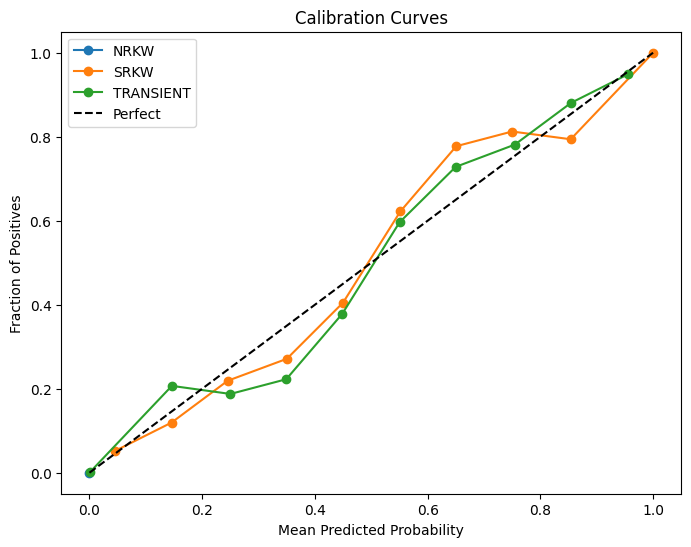

In [131]:
classes = np.unique(y_class)
evaluate_model(y_class, oof_lr, classes)

In [136]:
###########################################
# 1. Logistic Regression - Transient vs. SRKW


def collapse_labels(y):
    """Collapse NRKW into OTHER and keep SRKW/TRANSIENT."""
    y_bin = y.copy()
    y_bin = y_bin.replace({"NRKW": "OTHER"})
    # Drop OTHER rows entirely (NRKW + misc)
    y_bin = y_bin[y_bin.isin(["SRKW", "TRANSIENT"])]
    return y_bin


# Collapse labels
y_class_bin = collapse_labels(y_class)

# Match X to new y
X_class_bin = X_class.loc[y_class_bin.index]
groups_bin = groups.loc[y_class_bin.index]

print(y_class_bin.value_counts(normalize=True))


custom_weights = {
    "SRKW": 1.0,
    "TRANSIENT": 1.0,
}

log_reg = LogisticRegression(
    max_iter=2000,
    multi_class="multinomial",
    class_weight=custom_weights,
    solver="lbfgs",
    C=0.5,  # stronger regularization
)
log_model, oof_lr = train_classifier(
    X_class_bin,
    y_class_bin,
    groups=groups_bin,
    categorical_features=categorical_features,
    numeric_features=numerical_features,
    base_model=log_reg,
    sample_weights=sample_weights,
    n_splits=15,
    calibrate=True,
)

###########################################

POD_TYPE
SRKW         0.932727
TRANSIENT    0.067273
Name: proportion, dtype: float64


Accuracy: 0.981
Log Loss: 0.048

Confusion Matrix:
[[102057   1139]
 [   909   6534]]

Classification Report:
              precision    recall  f1-score   support

        SRKW       0.99      0.99      0.99    103196
   TRANSIENT       0.85      0.88      0.86      7443

    accuracy                           0.98    110639
   macro avg       0.92      0.93      0.93    110639
weighted avg       0.98      0.98      0.98    110639



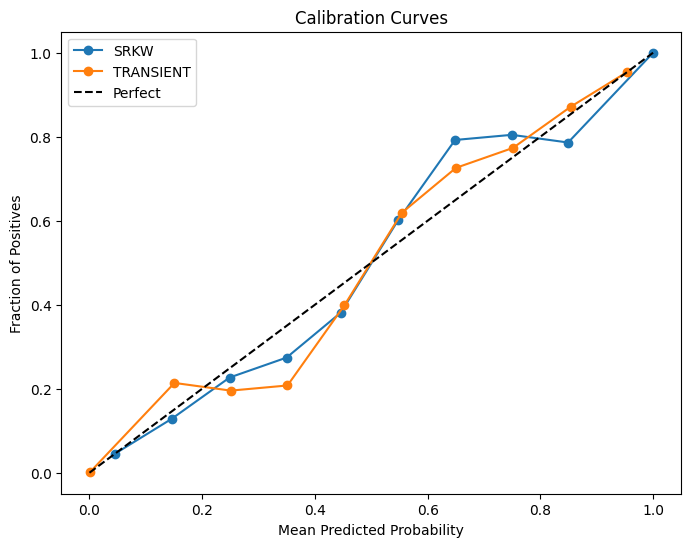

In [138]:
classes = np.unique(y_class_bin)
evaluate_model(y_class_bin, oof_lr, classes)

For practical purposes, we can say: The model can distinguish SRKW from TRANSIENT with ~93% macro F1, highly calibrated probabilities, and >98% accuracy.

NRKW sightings were excluded due to insufficient data (n=6). Classification restricted to SRKW vs TRANSIENT.

In [ ]:
log_model.estimator.nam

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['SOURCE', 'H3_CELL']),
                                                 ('num', StandardScaler(),
                                                  ['LATITUDE', 'LONGITUDE',
                                                   'DOY_SIN', 'DOY_COS'])])),
                ('model',
                 LogisticRegression(C=0.5,
                                    class_weight={'SRKW': 1.0,
                                                  'TRANSIENT': 1.0},
                                    max_iter=2000,
                                    multi_class='multinomial'))])

In [ ]:
import pandas as pd
import numpy as np

# Grab underlying pipeline if using CalibratedClassifierCV
pipeline = log_model.estimator
preprocessor = pipeline.named_steps["preprocessor"]
model = pipeline.named_steps["model"]

# Feature names
cat_features = preprocessor.transformers_[0][2]
num_features = preprocessor.transformers_[1][2]
ohe = preprocessor.named_transformers_["cat"]
ohe_features = ohe.get_feature_names_out(cat_features)
all_features = np.concatenate([ohe_features, num_features])

# Coefficients DataFrame
if model.coef_.shape[0] == 1:
    # Binary classification (coef for second class vs first)
    class_name = model.classes_[1]  # typically "TRANSIENT" in your case
    coefs = pd.DataFrame(model.coef_, columns=all_features, index=[class_name])
    coefs_sorted = coefs.T.sort_values(by=class_name, key=abs, ascending=False)
else:
    # Multiclass
    coefs = pd.DataFrame(model.coef_, columns=all_features, index=model.classes_)
    coefs["abs_SRKW_vs_TRANSIENT"] = np.abs(coefs.loc["TRANSIENT"] - coefs.loc["SRKW"])
    coefs_sorted = coefs.sort_values("abs_SRKW_vs_TRANSIENT", ascending=False)

coefs_sorted.head(15)

,TRANSIENT
SOURCE_TWM,-2.593508
SOURCE_ACARTIA,1.880447
H3_CELL_8628d115fffffff,-1.843813
H3_CELL_8628d1067ffffff,-1.730992
H3_CELL_8628d106fffffff,-1.345089
H3_CELL_8628d12b7ffffff,-1.337988
H3_CELL_8628d1157ffffff,-1.315364
H3_CELL_8628d114fffffff,-1.294538
H3_CELL_8628d12c7ffffff,-1.235272
H3_CELL_8628d1237ffffff,-1.131083


In [ ]:
import geopandas as gpd
import h3
import pandas as pd
import plotly.express as px

# ---------------------------------------
# 1. Identify misclassified TRANSIENTs
# ---------------------------------------
y_pred = log_model.predict(X_class_bin)
mis_idx = (y_class_bin == "TRANSIENT") & (y_pred == "SRKW")
X_mis = X_class_bin.loc[mis_idx].copy()


# ---------------------------------------
# 2. Map H3 cells to centroids
# ---------------------------------------
# Make a GeoDataFrame of H3 cells
def h3_to_latlon(h3_cells):
    lats, lons = [], []
    for cell in h3_cells:
        lat, lon = h3.cell_to_latlng(cell)
        lats.append(lat)
        lons.append(lon)
    return lats, lons


# Count misclassifications per H3 cell
mis_counts = X_mis["H3_CELL"].value_counts().reset_index()
mis_counts.columns = ["H3_CELL", "misclassified_count"]

# Get centroids
lats, lons = h3_to_latlon(mis_counts["H3_CELL"])
mis_counts["lat"] = lats
mis_counts["lon"] = lons

# ---------------------------------------
# 3. Optional: add total sightings for context
# ---------------------------------------
total_counts = X_class_bin["H3_CELL"].value_counts().reset_index()
total_counts.columns = ["H3_CELL", "total_count"]
mis_counts = mis_counts.merge(total_counts, on="H3_CELL", how="left")
mis_counts["misclassification_rate"] = (
    mis_counts["misclassified_count"] / mis_counts["total_count"]
)

# ---------------------------------------
# 4. Plot interactive heatmap
# ---------------------------------------
fig = px.scatter_mapbox(
    mis_counts,
    lat="lat",
    lon="lon",
    height=1000,
    size="misclassification_rate",  # relative bubble size
    color="misclassification_rate",  # color intensity
    hover_name="H3_CELL",
    hover_data=["misclassified_count", "total_count"],
    color_continuous_scale="Turbo",
    size_max=25,
    zoom=8,
    mapbox_style="carto-positron",
    title="Misclassified TRANSIENTs → SRKW by H3 Cell",
)

fig.show()

In [156]:
# ------------------------------
# 1️⃣ Prepare Local Sample Weights
# ------------------------------
# Compute per-cell class counts
cell_counts = X_class_bin.groupby("H3_CELL")["H3_CELL"].count()
transient_counts = (
    X_class_bin[y_class_bin == "TRANSIENT"].groupby("H3_CELL")["H3_CELL"].count()
)

# Local weights: rare TRANSIENTs get boosted
local_weights = 1 / (transient_counts + 1)  # avoid div-by-zero
sample_weights = X_class_bin["H3_CELL"].map(local_weights).fillna(1.0)


# Multiply by global class weight
global_class_weights = {"SRKW": 1.0, "TRANSIENT": 1.0}
sample_weights *= y_class_bin.map(global_class_weights)

# ------------------------------
# 2️⃣ H3 Parent Aggregation (Spatial Smoothing)
# ------------------------------
import h3

# Add H3 parent cells at one resolution up (e.g., res-4)
X_class_bin["H3_PARENT_4"] = X_class_bin["H3_CELL"].apply(
    lambda x: h3.cell_to_parent(x, 4)
)
X_class_bin["H3_PARENT_3"] = X_class_bin["H3_CELL"].apply(
    lambda x: h3.cell_to_parent(x, 3)
)

# Compute counts of TRANSIENTs in parent cells
parent_counts_4 = (
    X_class_bin[y_class_bin == "TRANSIENT"].groupby(X_class_bin["H3_PARENT_4"]).size()
)
parent_counts_3 = (
    X_class_bin[y_class_bin == "TRANSIENT"].groupby(X_class_bin["H3_PARENT_3"]).size()
)

X_class_bin["TRANSIENT_parent_4"] = (
    X_class_bin["H3_PARENT_4"].map(parent_counts_4).fillna(0)
)
X_class_bin["TRANSIENT_parent_3"] = (
    X_class_bin["H3_PARENT_3"].map(parent_counts_3).fillna(0)
)

# ------------------------------
# 3️⃣ Optional Oversampling of Rare Northern Cells
# ------------------------------
from sklearn.utils import resample

# Define threshold for "rare" H3 cells
rare_threshold = 3  # cells with <=3 sightings
rare_cells = (
    X_class_bin["H3_CELL"]
    .value_counts()[X_class_bin["H3_CELL"].value_counts() <= rare_threshold]
    .index
)

# Filter rare TRANSIENTs
transient_rare = X_class_bin[
    (y_class_bin == "TRANSIENT") & (X_class_bin["H3_CELL"].isin(rare_cells))
]

# Oversample
X_oversampled = pd.concat(
    [
        X_class_bin,
        resample(
            transient_rare,
            replace=True,
            n_samples=len(transient_rare) * 5,
            random_state=42,
        ),
    ]
)
y_oversampled = pd.concat(
    [
        y_class_bin,
        resample(
            y_class_bin[transient_rare.index],
            replace=True,
            n_samples=len(transient_rare) * 5,
            random_state=42,
        ),
    ]
)
sample_weights_oversampled = pd.concat(
    [
        sample_weights,
        resample(
            sample_weights[transient_rare.index],
            replace=True,
            n_samples=len(transient_rare) * 5,
            random_state=42,
        ),
    ]
)

# ------------------------------
# 4️⃣ Train Logistic Regression with updated features
# ------------------------------
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=2000, multi_class="multinomial", solver="lbfgs", C=0.5
)

# Feature columns: include original + H3 parent counts
all_features = (
    categorical_features
    + numerical_features
    + ["TRANSIENT_parent_4", "TRANSIENT_parent_3"]
)

log_model, oof_preds = train_classifier(
    X_oversampled[all_features],
    y_oversampled,
    groups=groups.loc[X_oversampled.index],  # make sure groups align
    categorical_features=categorical_features,
    numeric_features=numerical_features + ["TRANSIENT_parent_4", "TRANSIENT_parent_3"],
    base_model=log_reg,
    sample_weights=sample_weights_oversampled,
    n_splits=15,
    calibrate=True,
)

Accuracy: 0.981
Log Loss: 0.049

Confusion Matrix:
[[102028   1168]
 [   927   6921]]

Classification Report:
              precision    recall  f1-score   support

        SRKW       0.99      0.99      0.99    103196
   TRANSIENT       0.86      0.88      0.87      7848

    accuracy                           0.98    111044
   macro avg       0.92      0.94      0.93    111044
weighted avg       0.98      0.98      0.98    111044



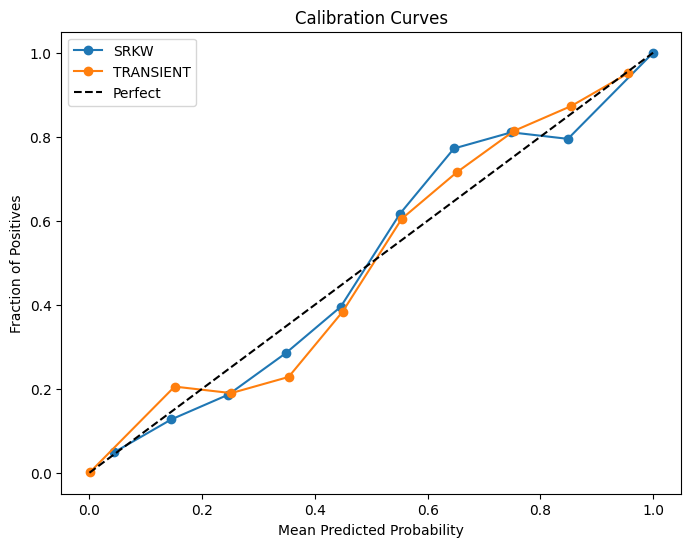

In [158]:
classes = np.unique(y_oversampled)
evaluate_model(y_oversampled, oof_preds, classes)

In [ ]:
# Oversampling + local H3 weighting boosted rare TRANSIENT predictions without hurting SRKW.

In [159]:
import geopandas as gpd
import h3
import pandas as pd
import plotly.express as px

# ---------------------------------------
# 1. Identify misclassified TRANSIENTs
# ---------------------------------------
y_pred = log_model.predict(X_class_bin)
mis_idx = (y_class_bin == "TRANSIENT") & (y_pred == "SRKW")
X_mis = X_class_bin.loc[mis_idx].copy()


# ---------------------------------------
# 2. Map H3 cells to centroids
# ---------------------------------------
# Make a GeoDataFrame of H3 cells
def h3_to_latlon(h3_cells):
    lats, lons = [], []
    for cell in h3_cells:
        lat, lon = h3.cell_to_latlng(cell)
        lats.append(lat)
        lons.append(lon)
    return lats, lons


# Count misclassifications per H3 cell
mis_counts = X_mis["H3_CELL"].value_counts().reset_index()
mis_counts.columns = ["H3_CELL", "misclassified_count"]

# Get centroids
lats, lons = h3_to_latlon(mis_counts["H3_CELL"])
mis_counts["lat"] = lats
mis_counts["lon"] = lons

# ---------------------------------------
# 3. Optional: add total sightings for context
# ---------------------------------------
total_counts = X_class_bin["H3_CELL"].value_counts().reset_index()
total_counts.columns = ["H3_CELL", "total_count"]
mis_counts = mis_counts.merge(total_counts, on="H3_CELL", how="left")
mis_counts["misclassification_rate"] = (
    mis_counts["misclassified_count"] / mis_counts["total_count"]
)

# ---------------------------------------
# 4. Plot interactive heatmap
# ---------------------------------------
fig = px.scatter_mapbox(
    mis_counts,
    lat="lat",
    lon="lon",
    height=1000,
    size="misclassification_rate",  # relative bubble size
    color="misclassification_rate",  # color intensity
    hover_name="H3_CELL",
    hover_data=["misclassified_count", "total_count"],
    color_continuous_scale="Turbo",
    size_max=25,
    zoom=8,
    mapbox_style="carto-positron",
    title="Misclassified TRANSIENTs → SRKW by H3 Cell",
)

fig.show()

In [161]:
# Assuming:
# oof_preds: (n_samples, n_classes) from train_classifier
# y_true: true labels (y_class or y_oversampled)
# classes: list or array of class names in same order as oof_preds

import pandas as pd
y_true = y_oversampled

# 1️⃣ Identify misclassified TRANSIENTs
pred_labels = classes[np.argmax(oof_preds, axis=1)]
mask_misclassified_transients = (y_true == 'TRANSIENT') & (pred_labels != 'TRANSIENT')

# 2️⃣ Extract probabilities for these cases
misclassified_probs = pd.DataFrame(
    oof_preds[mask_misclassified_transients],
    columns=classes,
    index=y_true.index[mask_misclassified_transients]
)

# 3️⃣ Quick summary
print(misclassified_probs.describe())

# 4️⃣ Optional: look at top “on-the-fence” cases
misclassified_probs['SRKW_vs_TRANSIENT_diff'] = misclassified_probs['SRKW'] - misclassified_probs['TRANSIENT']
top_uncertain = misclassified_probs.iloc[(misclassified_probs['SRKW_vs_TRANSIENT_diff'].abs()).argsort()[:20]]
print(top_uncertain)


             SRKW   TRANSIENT
count  927.000000  927.000000
mean     0.694802    0.305198
std      0.141720    0.141720
min      0.500265    0.000016
25%      0.575090    0.199994
50%      0.660190    0.339810
75%      0.800006    0.424910
max      0.999984    0.499735
            SRKW  TRANSIENT  SRKW_vs_TRANSIENT_diff
130567  0.500265   0.499735                0.000529
118688  0.500284   0.499716                0.000567
118687  0.500470   0.499530                0.000939
128510  0.500493   0.499507                0.000986
123427  0.501047   0.498953                0.002095
130205  0.501397   0.498603                0.002795
119960  0.502417   0.497583                0.004834
128019  0.502571   0.497429                0.005141
119975  0.503747   0.496253                0.007493
117557  0.503761   0.496239                0.007522
123254  0.503771   0.496229                0.007543
117292  0.503896   0.496104                0.007792
119959  0.504122   0.495878                0.008244
12

In [ ]:
import geopandas as gpd
import h3
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Ensure everything has the same index
X_bin_aligned = X_class_bin.loc[y_true.index]

# Mask misclassified TRANSIENTs
mask_misclassified_transients = (y_true == 'TRANSIENT') & (pred_labels != 'TRANSIENT')

# Select H3_CELL and predicted probability safely
df_misclassified = pd.DataFrame({
    'H3_CELL': X_bin_aligned.loc[mask_misclassified_transients, 'H3_CELL'],
    'TRANSIENT_PROBA': oof_preds[mask_misclassified_transients, classes.tolist().index('TRANSIENT')]
})


# ----------------------------
# 2️⃣ Aggregate by H3 cell to get mean probability
# ----------------------------
grid_probs = df_misclassified.groupby('H3_CELL')['TRANSIENT_PROBA'].mean().reset_index()

# ----------------------------
# 3️⃣ Convert H3 to polygons
# ----------------------------
def h3_to_polygon(h):
    boundary = h3.cell_to_boundary(h)
    return gpd.GeoSeries([Polygon(boundary)])

    grid_probs['geometry'] = grid_probs['H3_CELL'].apply(
    lambda h: Polygon([(lon, lat) for lat, lon in h3.h3_to_geo_boundary(h, geo_json=True)])
)

grid_probs['geometry'] = grid_probs['H3_CELL'].apply(lambda h: gpd.GeoSeries([Polygon([(lon, lat) for lat, lon in h3.cell_to_boundary(h)])])[0])
gdf = gpd.GeoDataFrame(grid_probs, geometry='geometry', crs="EPSG:4326")

gdf.explore('TRANSIENT_PROBA', cmap = 'RdBu').save('transient_ms.html')

=== OOF Verification Summary ===
Samples: 110645 | Classes: 3
Row-sum ~1.0? [1.000000, 1.000000]
Accuracy: 0.9812
LogLoss:  0.0491  | Baseline (entropy): 0.2471
Brier (multiclass): 0.0290
ECE (top-label):    0.0040

Class prevalence: {'NRKW': np.float64(5.4227484296624336e-05), 'SRKW': np.float64(0.9326765782457409), 'TRANSIENT': np.float64(0.06726919426996249)}
Mean predicted prob by class: {'NRKW': np.float64(1.777385955537351e-05), 'SRKW': np.float64(0.9327657301942638), 'TRANSIENT': np.float64(0.06721649594618577)}

Per-fold metrics (head):
    fold  n_val  accuracy  log_loss
0     0   7377  0.983462  0.040436
1     1   7377  0.978582  0.053296
2     2   7377  0.984818  0.037432
3     3   7377  0.985360  0.035028
4     4   7377  0.978175  0.049199

Bootstrap 95% CIs: {'accuracy_mean': 0.9812067965113651, 'accuracy_95CI': (0.9803780107551177, 0.9820507026978174), 'logloss_mean': 0.04911095203474912, 'logloss_95CI': (0.04736253425045297, 0.05081830729810729)}

Classification report:


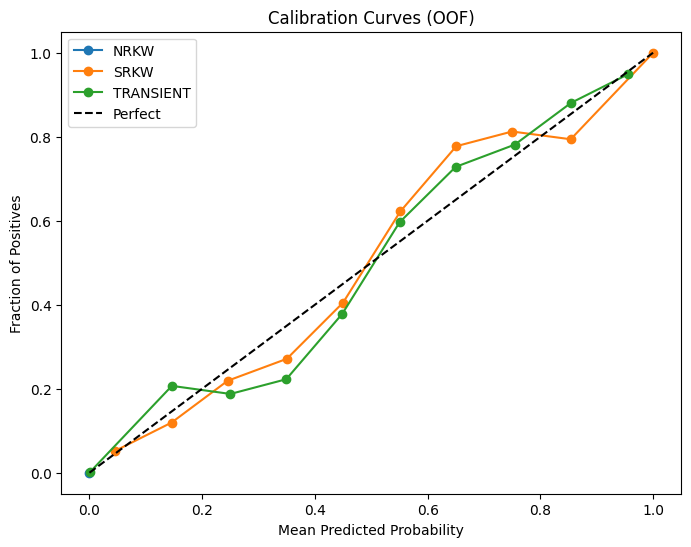

,bin_low,bin_high,accuracy,confidence,count
0,0.000000,0.066667,NaN,NaN,0
1,0.066667,0.133333,NaN,NaN,0
2,0.133333,0.200000,NaN,NaN,0
3,0.200000,0.266667,NaN,NaN,0
4,0.266667,0.333333,NaN,NaN,0
5,0.333333,0.400000,NaN,NaN,0
6,0.400000,0.466667,NaN,NaN,0
7,0.466667,0.533333,0.509128,0.516196,493
8,0.533333,0.600000,0.654545,0.566351,1100
9,0.600000,0.666667,0.751926,0.634643,1298


In [ ]:
# --------- RUN AUDIT ---------
classes_used = np.unique(y_class)
audit = {}

# 1) Sanity checks on OOF probabilities
audit["proba_sanity"] = verify_probabilities(oof_lr, classes_used)

# 2) Core metrics vs baseline
audit["accuracy"] = float(accuracy_score(y_class, classes_used[oof_lr.argmax(axis=1)]))
audit["log_loss"] = float(log_loss(y_class, oof_lr, labels=classes_used))

baseline_ll, prev = baseline_entropy(y_class, classes_used)
audit["baseline_log_loss_entropy"] = baseline_ll
audit["class_prevalence"] = prev

# 3) Brier + ECE
audit["brier_multiclass"] = multiclass_brier(y_class, oof_lr, classes_used)
audit["ece_toplabel"], ece_table = top_label_ece(
    y_class, oof_lr, classes_used, n_bins=15
)

# 4) ROC-AUC (one-vs-rest), if feasible
try:
    Y_bin = label_binarize(y_class, classes=classes_used)
    audit["roc_auc_ovr_macro"] = float(
        roc_auc_score(Y_bin, oof_lr, average="macro", multi_class="ovr")
    )
except Exception as e:
    audit["roc_auc_ovr_macro"] = f"unavailable: {e}"

# 5) Per-fold diagnostics (recreated from groups)
audit["per_fold"] = per_fold_metrics(y_class, oof_lr, groups, classes_used, n_splits=15)

# 6) Bootstrap CIs
audit["bootstrap_CIs"] = bootstrap_ci(
    y_class, oof_lr, classes_used, n_boot=1000, seed=42
)

# 7) Full classification report
audit["classification_report"] = classification_report(
    y_class, classes_used[oof_lr.argmax(axis=1)], labels=classes_used, zero_division=0
)

# 8) Compare mean predicted probs to prevalence (calibration-at-aggregate)
audit["mean_predicted_prob_by_class"] = dict(zip(classes_used, oof_lr.mean(axis=0)))

# 9) Extract LR coefficients (if LR final estimator)
audit["lr_feature_importance"] = extract_lr_coefficients(log_model)

# 10) Print summary
print("=== OOF Verification Summary ===")
print(
    f"Samples: {audit['proba_sanity']['n_samples']} | Classes: {audit['proba_sanity']['n_classes']}"
)
print(
    f"Row-sum ~1.0? [{audit['proba_sanity']['row_sum_min']:.6f}, {audit['proba_sanity']['row_sum_max']:.6f}]"
)
print(f"Accuracy: {audit['accuracy']:.4f}")
print(
    f"LogLoss:  {audit['log_loss']:.4f}  | Baseline (entropy): {audit['baseline_log_loss_entropy']:.4f}"
)
print(f"Brier (multiclass): {audit['brier_multiclass']:.4f}")
print(f"ECE (top-label):    {audit['ece_toplabel']:.4f}")
print("\nClass prevalence:", audit["class_prevalence"])
print("Mean predicted prob by class:", audit["mean_predicted_prob_by_class"])
print("\nPer-fold metrics (head):\n", audit["per_fold"].head())
print("\nBootstrap 95% CIs:", audit["bootstrap_CIs"])
print("\nClassification report:\n", audit["classification_report"])

# 11) Nice-to-have plots
plot_calibration_curves(y_class, oof_lr, classes_used)

# Optional: visualize ECE table
display(ece_table.head(12))

#### Support Vector Machine (SVM)

In [38]:
# 2. SVM (probability=True so it outputs probs)
svm = LinearSVC()

svm_model, oof_svm = train_classifier(
    X_class,
    y_class,
    groups=groups,
    categorical_features=categorical_features,
    numeric_features=numerical_features,
    base_model=svm,
    sample_weights=sample_weights,
    n_splits=10,
    calibrate=False,
)

⚠️ LinearSVC has no predict_proba. Wrapping with CalibratedClassifierCV (sigmoid).


Accuracy: 0.970
Log Loss: 0.064
Confusion Matrix:
[[     0      6      0]
 [     0 100114   3082]
 [     0    264   7179]]

Classification Report:
              precision    recall  f1-score   support

        NRKW       0.00      0.00      0.00         6
        SRKW       1.00      0.97      0.98    103196
   TRANSIENT       0.70      0.96      0.81      7443

    accuracy                           0.97    110645
   macro avg       0.57      0.64      0.60    110645
weighted avg       0.98      0.97      0.97    110645



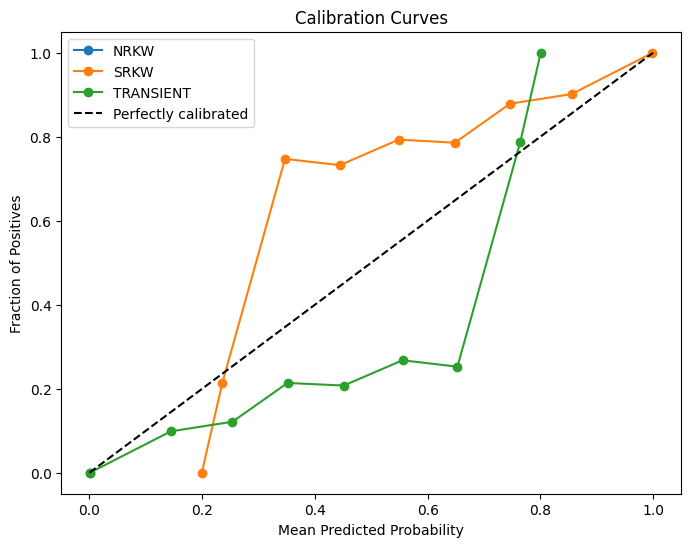

In [39]:
classes = np.unique(y_class)
evaluate_model(y_class, oof_svm, classes)

#### XG Boost

In [40]:
# Filter out NRKW from your training data
mask = y_class != "NRKW"  # keep only SRKW and Transient
X_class_filtered = X_class[mask].reset_index(drop=True)
y_class_filtered = y_class[mask].reset_index(drop=True)
groups_filtered = groups[mask].reset_index(drop=True) if groups is not None else None
sample_weights_filtered = (
    sample_weights[mask].reset_index(drop=True) if sample_weights is not None else None
)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_class_filtered)  # 0 = SRKW, 1 = Transient
# scale_pos_weight = len(y_encoded[y_encoded == 0]) / len(y_encoded[y_encoded == 1])
y_encoded = pd.Series(y_encoded, index=y_class_filtered.index)
unique_classes = np.unique(y_encoded)

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    objective="multi:softprob",
    n_estimators=500,
    eval_metric="mlogloss",
    learning_rate=0.05,
    max_depth=6,
    num_class=len(unique_classes),
)

xgb_trained, oof_xgb = train_classifier(
    X_class_filtered,
    y_encoded,
    groups=groups_filtered,
    categorical_features=categorical_features,
    numeric_features=numerical_features,
    base_model=xgb_model,
    sample_weights=sample_weights_filtered,
    n_splits=10,
    calibrate=True,
)

# Convert predictions back to original labels
pred_labels = le.inverse_transform(np.argmax(oof_xgb, axis=1))

In [41]:
mask = y_class != "NRKW"
y_class_filtered = y_class[mask].reset_index(drop=True)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

acc = accuracy_score(y_class_filtered, pred_labels)
print("Accuracy:", acc)
print(
    "Confusion Matrix:\n",
    confusion_matrix(y_class_filtered, pred_labels, labels=["SRKW", "TRANSIENT"]),
)
print(
    classification_report(y_class_filtered, pred_labels, labels=["SRKW", "TRANSIENT"])
)

Accuracy: 0.9823028046168168
Confusion Matrix:
 [[102166   1030]
 [   928   6515]]
              precision    recall  f1-score   support

        SRKW       0.99      0.99      0.99    103196
   TRANSIENT       0.86      0.88      0.87      7443

    accuracy                           0.98    110639
   macro avg       0.93      0.93      0.93    110639
weighted avg       0.98      0.98      0.98    110639



In [42]:
################################################################################

In [ ]:
# Implications for modeling
# NRKW predictions being zero is not a dealbreaker here.
# Only 6 sightings; you literally don’t have enough signal to learn anything meaningful from the OTHER class about NRKW.
# Trying to force predictions could add noise rather than signal.
# SRKW and Transient predictions are the key for the downstream presence model.
# If your OOF predictions correctly classify these two, then your “OTHER” sightings are effectively usable.
# You can inject them as probabilistic SRKW/Transient labels into the presence model.
# Geography is your friend.
# “OTHER” sightings near the San Juans → SRKW
# Farther north → could be Transient or rare NRKW
# The model will learn these spatial patterns naturally if H3-cell + latitude/longitude are included as features.


# Don’t obsess over the NRKW metrics for the OTHER classification — they are essentially irrelevant in your range.
# Focus on precision, recall, F1 for SRKW and Transient, because they dominate what you’ll feed into the next model.
# Calibration is still important — you want the predicted probabilities to reflect uncertainty, especially for ambiguous OTHER sightings.

# Current logistic regression / OOF predictions look good for SRKW and Transient → you’re fine for downstream presence modeling.
# NRKW can be ignored in this context; if the rare northern sightings appear in your dataset, the model might predict them as low-probability SRKW or Transient, which is acceptable given the small count.
# Keep spatial features, time-of-year, and any observer metadata to help the model infer SRKW vs Transient patterns from OTHER sightings.

# Optional extras:
# Stratified metrics by BLOCK / YEAR — check if some regions or years are systematically misclassified.
# Top-K accuracy — sometimes useful if you want the most probable 2 predictions for downstream modeling.

# If you want, I can also whip up a visual spatiotemporal validation — like a map showing where “OTHER” predictions were likely SRKW/NRKW/Transient,
# so you can eyeball them against known patterns. That’s super clutch for sanity checks before feeding probabilities downstream.

#### Voting Ensemble

In [61]:
# # After encoding
# le = LabelEncoder()
# y_encoded = le.fit_transform(y_class)

# # Build numeric-mapped weights
# custom_weights = {
#     le.transform([cls])[0]: w
#     for cls, w in {"SRKW": 1.0, "TRANSIENT": 2.0, "NRKW": 0.5}.items()
# }


# # Voting Ensemble:
# models_list = [
#     (
#         "log",
#         LogisticRegression(
#             max_iter=2000,
#             multi_class="multinomial",
#             class_weight=custom_weights,
#             solver="lbfgs",
#             C=0.5,  # stronger regularization
#         ),
#     ),
#     ("rf", RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=5)),
#     (
#         "xgb",
#         xgb.XGBClassifier(
#             objective="multi:softprob",
#             n_estimators=500,
#             eval_metric="mlogloss",
#             learning_rate=0.05,
#             max_depth=6,
#         ),
#     ),
# ]

# model, oof_voting = train_ensemble(
#     X_class,
#     y_class,
#     groups=sightings_data_class["BLOCK"],
#     models=models_list,
#     ensemble_mode="voting",
#     categorical_features=categorical_features,
#     numeric_features=numerical_features,
#     voting_type="soft",
# )

In [62]:
# classes = np.unique(y_class)
# evaluate_model(y_class, oof_voting, classes)

#### Stacked Ensemble

In [63]:
# # Stacking Ensemble:
# stack_models = [
#     (
#         "log",
#         LogisticRegression(
#             max_iter=2000,
#             multi_class="multinomial",
#             class_weight=custom_weights,
#             solver="lbfgs",
#             C=0.5,  # stronger regularization
#         ),
#     ),
#     # ("rf", RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=5)),
#     (
#         "xgb",
#         xgb.XGBClassifier(
#             objective="multi:softprob",
#             n_estimators=500,
#             eval_metric="mlogloss",
#             learning_rate=0.05,
#             max_depth=6,
#         ),
#     ),
# ]

# model, oof_stack = train_ensemble(
#     X_class,
#     y_class,
#     groups=sightings_data_class["BLOCK"],
#     models=stack_models,
#     ensemble_mode="stacking",
#     final_estimator=LogisticRegression(max_iter=2000),
#     categorical_features=categorical_features,
#     numeric_features=numerical_features,
# )

In [64]:
# classes = np.unique(y_class)
# evaluate_model(y_class, oof_stack, classes)

#### Predicting Pod Tag

Class balance → are J/K/L evenly represented, or is one super dominant? If not, you’ll need class weights / resampling.
Features → are there pod-level features in your data (geography, call types, seasonality)? Because pods often segregate spatially and temporally.
Cross-validation → make sure your folds don’t split individuals (e.g., all J pod in training, none in val). You’ll want group-based CV so pods/general contexts are represented across folds.

In [ ]:
sightings_data_class.POD_TAG.value_counts(normalize=True)

POD_TAG
J    0.411361
L    0.273668
K    0.247648
T    0.067269
A    0.000018
G    0.000018
R    0.000018
Name: proportion, dtype: float64

In [94]:
################################################################################
# MODEL - PREPROCESSING PIPELINE


# 1. Select Features + Response Variables
features = [
    "LATITUDE",
    "LONGITUDE",
    "DOY_SIN",
    "DOY_COS",
    "WOY_SIN",
    "WOY_COS",
    "MONTH_SIN",
    "MONTH_COS",
    # "SOURCE",
    "H3_CELL",
]
response = "POD_TAG"

# 2. Build Feature Matrix
X_class, y_class = build_feature_matrix(sightings_data_class, features, response)
sample_weights = sightings_data_class["COUNT"]
groups = sightings_data_class["BLOCK"]

# 3. Define Categorical Features
categorical_features = [feat for feat in features if feat in ["SOURCE", "H3_CELL"]]
numerical_features = [feat for feat in features if feat not in ["SOURCE", "H3_CELL"]]

################################################################################

In [87]:
# Step 2: Pod classifier (J/K/L)
mask_pods = y_class.isin(["J", "K", "L"])
X_stage2 = X_class[mask_pods].reset_index(drop=True)
y_stage2 = y_class[mask_pods].reset_index(drop=True)
groups_stage2 = groups[mask_pods].reset_index(drop=True)

le_stage2 = LabelEncoder()
y_stage2_enc = le_stage2.fit_transform(y_stage2)  # 0=J, 1=K, 2=L
y_stage2_enc = pd.Series(y_stage2_enc, index=y_stage2.index)
unique_classes = np.unique(y_stage2_enc)

custom_weights = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
}

# base_model = LogisticRegression(
#     max_iter=2000,
#     multi_class="multinomial",
#     class_weight=custom_weights,
#     solver="lbfgs",
#     C=0.5,
# )

# base_model = RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=-1)

base_model = xgb.XGBClassifier(
    n_estimators=300, max_depth=8, tree_method="hist", eval_metric="mlogloss", n_jobs=-1
)


stage2_model, oof_stage2 = train_classifier(
    X_stage2,
    y_stage2_enc,
    groups=groups[mask_pods],
    categorical_features=categorical_features,
    numeric_features=numerical_features,
    base_model=base_model,
    sample_weights=sample_weights[mask_pods],
    n_splits=15,
    calibrate=True,
)

Accuracy: 0.460
Log Loss: 1.054
Confusion Matrix:
[[32204  3871  9440]
 [16099  3729  7573]
 [15924  2844 11512]]

Classification Report:


/opt/anaconda3/envs/salmonsignal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.50      0.71      0.59     45515
           1       0.36      0.14      0.20     27401
           2       0.40      0.38      0.39     30280

    accuracy                           0.46    103196
   macro avg       0.42      0.41      0.39    103196
weighted avg       0.43      0.46      0.43    103196



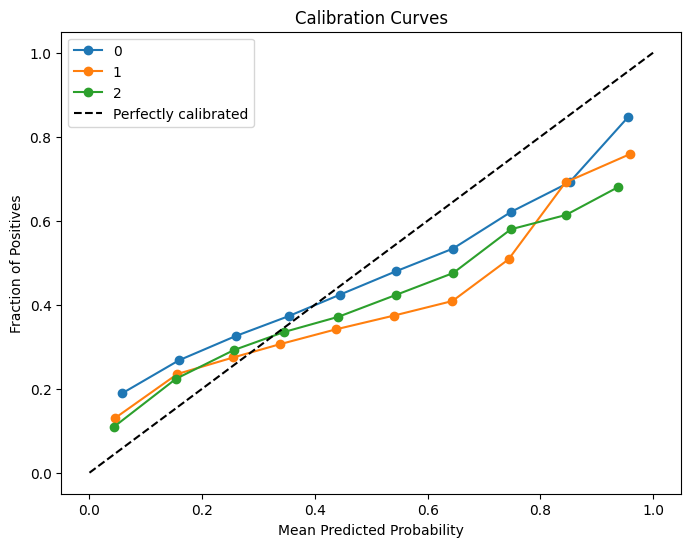

In [89]:
classes = np.unique(y_stage2_enc)
evaluate_model(y_stage2_enc, oof_stage2, classes)

In [ ]:
# One vs Rest

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GroupKFold
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import numpy as np
import pandas as pd

# ---- Step 0: Filter pods ----
mask_pods = y_class.isin(["J", "K", "L"])
X_pods = X_class[mask_pods].reset_index(drop=True)
y_pods = y_class[mask_pods].reset_index(drop=True)
groups_pods = groups[mask_pods].reset_index(drop=True)

# ---- Encode labels ----
le = LabelEncoder()
y_encoded = le.fit_transform(y_pods)  # 0=J, 1=K, 2=L
classes = np.unique(y_encoded)

# ---- Preprocessing ----
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numerical_features),
    ]
)

# ---- Apply preprocessing ----
# X_processed = preprocessor.fit_transform(X_pods)
# ---- Apply preprocessing (convert to dense) ----
X_processed = preprocessor.fit_transform(X_pods).toarray()

# ---- OOF predictions array ----
oof_preds = np.zeros((len(X_pods), len(classes)))

# ---- GroupKFold ----
gkf = GroupKFold(n_splits=5)

# ---- One-vs-Rest with XGBoost ----
for fold, (train_idx, val_idx) in enumerate(
    gkf.split(X_processed, y_encoded, groups_pods)
):
    X_train, X_val = X_processed[train_idx], X_processed[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

    fold_preds = np.zeros((len(X_val), len(classes)))

    for i, c in enumerate(classes):
        # Binary labels for this OVR classifier
        y_bin = (y_train == c).astype(int)
        # Optional: compute pos weight for imbalance
        scale_pos_weight = max(1.0, (len(y_bin) - y_bin.sum()) / y_bin.sum())

        xgb_clf = xgb.XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            n_jobs=-1,
        )

        # Fit model with sample weight
        xgb_clf.fit(
            X_train, y_bin, sample_weight=np.where(y_bin == 1, scale_pos_weight, 1.0)
        )

        # Predict probabilities
        fold_preds[:, i] = xgb_clf.predict_proba(X_val)[:, 1]

    oof_preds[val_idx] = fold_preds

# ---- Calibrate final OVR classifier ----
# Fit on full dataset for final predictions
final_preds = np.zeros((len(X_pods), len(classes)))
final_models = []

for i, c in enumerate(classes):
    y_bin = (y_encoded == c).astype(int)
    scale_pos_weight = max(1.0, (len(y_bin) - y_bin.sum()) / y_bin.sum())

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        n_jobs=-1,
    )

    xgb_clf.fit(
        X_processed, y_bin, sample_weight=np.where(y_bin == 1, scale_pos_weight, 1.0)
    )

    # Calibrate
    calibrator = CalibratedClassifierCV(xgb_clf, cv="prefit", method="isotonic")
    calibrator.fit(X_processed, y_bin)
    final_models.append(calibrator)

    final_preds[:, i] = calibrator.predict_proba(X_processed)[:, 1]

# ---- Convert back to pod labels ----
pred_labels = le.inverse_transform(np.argmax(final_preds, axis=1))

# ---- You can now evaluate pred_labels vs y_pods ----

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

pred_labels = le_stage2.inverse_transform(np.argmax(oof_preds, axis=1))
print("Accuracy:", accuracy_score(y_pods, pred_labels))
print(
    "Confusion Matrix:\n", confusion_matrix(y_pods, pred_labels, labels=["J", "K", "L"])
)
print(classification_report(y_pods, pred_labels, labels=["J", "K", "L"]))

Accuracy: 0.4234466452188069
Confusion Matrix:
 [[17848 12913 14754]
 [ 6118 10131 11152]
 [ 5571  8990 15719]]
              precision    recall  f1-score   support

           J       0.60      0.39      0.48     45515
           K       0.32      0.37      0.34     27401
           L       0.38      0.52      0.44     30280

    accuracy                           0.42    103196
   macro avg       0.43      0.43      0.42    103196
weighted avg       0.46      0.42      0.43    103196



#### Acceptance Policy for Using OTHER in Downstream Models

We won’t hard-assign labels. Two options:
- Soft-label ingestion: pass p(type) and p(tag|type) into presence models as covariates; or use expected label indicators E[1_{class}] = p(class).
- Monte Carlo label draws: sample K label realizations from the classifier per record, fit the presence model K times (or via bagging-like resampling), then average predictions. This propagates label uncertainty.<br>

Eligibility thresholds:
- If max p(type) ≥ 0.7 and calibration OK → include as soft label with full weight.
- If 0.5 ≤ max p(type) < 0.7 → include with down-weight (e.g., ×0.5) and flag.
- If max p(type) < 0.5 or OOD → keep as OTHER (excluded from pod-specific labeling but available as unlabeled signal).

#### Integration into Pod-Specific Presence Models

Add features: p_SRKW, p_NRKW, p_Transient and, conditionally, p_J, p_K, p_L.<br>
For presence targets built from mixed sources, weight examples by Effort Index × classification confidence.<br>

Compare three training modes:<br>
- No-OTHER baseline.
- Soft OTHER (probabilities as covariates only).
- Imputed OTHER (Monte Carlo labels).
- Evaluate lift on spatiotemporal holdout and by marine area.

#### Risks & Mitigations

Observer bias leaks → include Effort Index; block CV; penalize overfit features.<br>
Catastrophic mislabeling of SRKW → cost matrix + reject option + manual review queue.<br>
Domain drift (new areas/conditions) → OOD detection + drift monitors + regular recalibration.<br>
Text noise/ambiguity → curate lexicons; consider small domain LM for entity hints; keep NLP features bounded.<br>

<br><br>

***

<center><b>END OF NOTEBOOK</b></center>

***